# PCA and LDA

This exercise tries to show the basics on how to use PCA and LDA to perform unsupervised (PCA) and supervised (LDA) dimensionality reduction, in order to obtain better classification results.

The exercise is based on the [Wine dataset](https://archive.ics.uci.edu/ml/datasets/wine), which is a multinomial classification problem with 13 numerical features and 178 samples.

In [74]:
# Imports
import warnings

warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
from dataset import Dataset
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns; sns.set()
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from matplotlib import pyplot

Read the Wine dataset

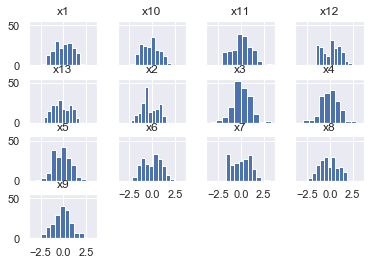

In [76]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine = Dataset(url, header=None, delimiter=',')
wine.set_target('x0').scale().fix_skewness()

# Plot the histograms of the features
wine.features.hist(sharex=True, sharey=True)
plt.show();

## PCA

Applying PCA to the dataset is extremely simple. Let's do it specifying the number of components, and print out the explained variance from each of the components, by accessing the internal property of `pca` called `explained_variance_ratio_` which is an array of `n_components`.

In [23]:
pca = PCA(n_components=3)
X = pca.fit(wine.features).transform(wine.features)
y = wine.target

In [24]:
# Percentage of variance explained for each components
explained_variance = pca.explained_variance_ratio_
num_components = len(explained_variance)
print('Explained variance (first {} components): {}'.format(
    len(explained_variance), str(explained_variance)))

Explained variance (first 3 components): [0.35842351 0.20290883 0.11730487]


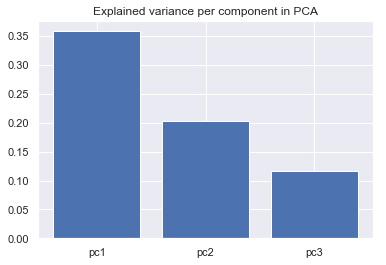

In [25]:
plt.bar(range(num_components), explained_variance)
plt.xticks(range(num_components), ('pc1', 'pc2', 'pc3'))
plt.title('Explained variance per component in PCA')
plt.show();

Now, the interpretation. We will make three plots

  1. PC1 vs. PC2
  2. PC1 vs. PC3
  3. PC2 vs. PC3
  
to see which one helps me more in separating the three different classes in the dataset.

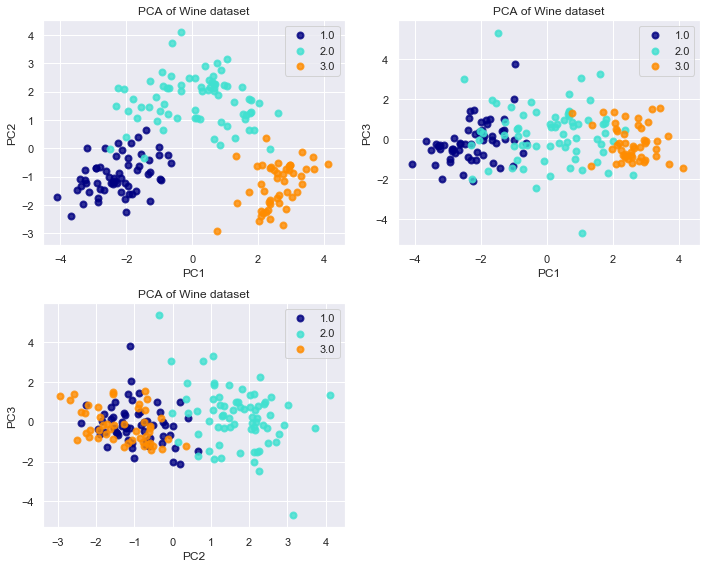

In [26]:
def plot_pc(pc_i, pc_j):
    target_names = list(wine.target.unique())
    #plt.figure()
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    for color, i in zip(colors, target_names):
        plt.scatter(X[wine.target == i, pc_i], X[wine.target == i, pc_j], 
                    color=color, alpha=.8, lw=lw,
                    label=i)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of Wine dataset')
    plt.xlabel('PC{}'.format(pc_i+1)); plt.ylabel('PC{}'.format(pc_j+1))

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plot_pc(0, 1)
plt.subplot(2,2,2)
plot_pc(0, 2)
plt.subplot(2,2,3)
plot_pc(1, 2)
plt.tight_layout()
plt.show();

## LDA

In [78]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit(wine.features, wine.target).transform(wine.features)

X_lda.shape

(178, 2)

Let's take a look to the scaling vectors produced by the LDA. These are the ones you should use to re-scale all your input in order to be translated to a new set of axis where the ratio between-classes by within-classes is maximized. They're inside the `lda` object as a property called `scalings_`.

In [65]:
def printArray(arr):
    for row in arr:
        for item in row:
            print("{:6.1f}".format(item), end = " ")
        print("")

printArray(lda.scalings_)

  -0.3    0.7 
   0.2    0.5 
  -0.1    0.5 
   0.5   -0.5 
  -0.0   -0.0 
   0.4   -0.0 
  -1.9   -0.4 
  -0.2   -0.2 
   0.1   -0.2 
   1.2    0.8 
  -0.2   -0.2 
  -0.6    0.2 
  -0.8    1.0 


We can only represent the first two linear discrinant vectors (aka: scaling vectors). We see how weel a 13-dimensional problem can now be easily plotted and solved.

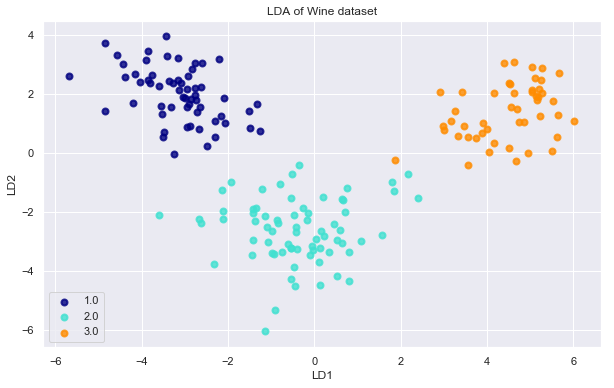

In [80]:
def plot_ld(ld_i, ld_j):
    target_names = list(wine.target.unique())
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    for color, i in zip(colors, target_names):
        plt.scatter(X_lda[wine.target == i, ld_i], X_lda[wine.target == i, ld_j], 
                    color=color, alpha=.8, lw=lw,
                    label=i)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of Wine dataset')
    plt.xlabel('LD{}'.format(ld_i+1)); plt.ylabel('LD{}'.format(ld_j+1))

plt.figure(figsize=(10,6))
plot_ld(0, 1)
plt.show();

### Predicting with LDA.

In [81]:
# Split the dataset.
X, y = wine.split()
lda = LinearDiscriminantAnalysis().fit(X.train, y.train)

# Evaluate using cross-validation, what is the performance in training.
accuracies = cross_val_score(lda, X=X.train, y=y.train, scoring='accuracy')
print('Avg. Acc (training): {:.2f} +/- {:.2f}'.format(
    np.mean(accuracies), np.std(accuracies)))

# Finally, evaluate my model in test.
test_score = accuracy_score(y.test, lda.predict(X.test))
print('Acc (test): {:.2f}'.format(test_score))

Avg. Acc (training): 0.99 +/- 0.02
Acc (test): 0.94
